# =============================================================================
# BENCHMARK EVALUATION NOTEBOOK
# =============================================================================
## Purpose:
    - Load the baseline model, processed test data, and the best action determined by the RL agent.
    - Apply the baseline configuration, manual optimization strategies (pruning, quantization), and the agent-discovered optimization strategy.
    - Perform a comprehensive benchmark evaluation (N=10 runs) for statistical robustness.
    - Report metrics (Accuracy, Latency, Energy, Params, FLOPs) as Mean ± Standard Deviation.
    - Visualize the comparative performance results based on mean values.
# =============================================================================

# === Clone Repository & Install Dependencies ===

In [72]:
!rm -rf Sustainable_AI_Agent_Project
!git clone https://github.com/trongjhuongwr/Sustainable_AI_Agent_Project.git
%cd Sustainable_AI_Agent_Project

Cloning into 'Sustainable_AI_Agent_Project'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 53 (delta 18), reused 42 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 937.23 KiB | 12.84 MiB/s, done.
Resolving deltas: 100% (18/18), done.
/kaggle/working/Sustainable_AI_Agent_Project/Sustainable_AI_Agent_Project/Sustainable_AI_Agent_Project/Sustainable_AI_Agent_Project/Sustainable_AI_Agent_Project/Sustainable_AI_Agent_Project/Sustainable_AI_Agent_Project/Sustainable_AI_Agent_Project


In [73]:
!pip install -q --extra-index-url https://download.pytorch.org/whl/cu121 -r /kaggle/working/Sustainable_AI_Agent_Project/requirements.txt

In [74]:
# Uninstall torchvision to prevent import conflicts with ptflops/pytorch
!pip uninstall -y torchvision
print("Torchvision uninstalled.")

Torchvision uninstalled.


# 1. Import Libraries and Configuration

In [75]:
import os
import warnings
import logging
import json
import copy
import random
from tqdm.notebook import tqdm

# Suppress specific warnings for cleaner output
os.environ["GYM_DISABLE_WARNINGS"] = "true"
warnings.filterwarnings("ignore", module="gymnasium")
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("gymnasium").setLevel(logging.ERROR)
logging.getLogger("stable_baselines3").setLevel(logging.ERROR)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import gymnasium as gym # Required for potential agent loading fallback
from gymnasium import spaces # Required for potential agent loading fallback
from sklearn.metrics import accuracy_score
from stable_baselines3 import PPO # Required for potential agent loading fallback
from codecarbon import EmissionsTracker
from ptflops import get_model_complexity_info
import torch_pruning as tp
import matplotlib.pyplot as plt
import seaborn as sns
from builtins import print as builtin_print
import time

print("Libraries imported successfully.")

Libraries imported successfully.


# 2. Configuration Class

In [76]:
# Defines hyperparameters, file paths, and evaluation parameters.
class Config:
    # --- Input Paths ---
    PROCESSED_DATA_PATH = '/kaggle/input/baseline-model-saa/processed_data.pt' # Path to processed data tensors
    BASELINE_MODEL_PATH = '/kaggle/input/baseline-model-saa/baseline_model.pth' # Path to baseline model state dictionary
    AGENT_SAVE_PATH = "/kaggle/input/train-rl-agent-done/sustainable_ai_agent_ppo" # Path to saved PPO agent (fallback)
    BEST_ACTION_PATH = "/kaggle/input/train-rl-agent-done/best_action.json" # Preferred path for best action info

    # --- Data Parameters ---
    SEQUENCE_LENGTH = 30
    INPUT_DIM = 4

    # --- Model Architecture Parameters (must match baseline) ---
    HIDDEN_DIM = 256
    N_LAYERS = 2
    OUTPUT_DIM = 1
    DROPOUT = 0.2
    SEED = 42 # For reproducibility if agent needs loading

    # --- Evaluation Parameters ---
    EVAL_BATCH_SIZE = 64
    CODECARBON_BATCHES = 10 # Batches for energy measurement
    N_RUNS = 10

    # --- Computation Device ---
    # Evaluation typically runs on CPU for consistent energy metrics,
    # but DEVICE might be needed if loading the agent requires GPU context.
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds (primarily relevant if agent needs to be loaded and predict)
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)


# Set initial seed (will be reset for each run)
set_seed(Config.SEED)


print(f"Configuration loaded. Evaluation device preference: CPU for metrics.")
print(f"Statistical runs planned: {Config.N_RUNS}")
print(f"Loading data from: {Config.PROCESSED_DATA_PATH}")
print(f"Loading baseline model from: {Config.BASELINE_MODEL_PATH}")
print(f"Attempting to load best action from: {Config.BEST_ACTION_PATH}")
print(f"Agent path (fallback): {Config.AGENT_SAVE_PATH}")

Configuration loaded. Evaluation device preference: CPU for metrics.
Statistical runs planned: 10
Loading data from: /kaggle/input/baseline-model-saa/processed_data.pt
Loading baseline model from: /kaggle/input/baseline-model-saa/baseline_model.pth
Attempting to load best action from: /kaggle/input/train-rl-agent-done/best_action.json
Agent path (fallback): /kaggle/input/train-rl-agent-done/sustainable_ai_agent_ppo


# 3. Utility Functions and Model Definition

In [77]:
# Replicated from previous notebooks for standalone execution capability.

def count_parameters(model):
    """Counts trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate_model(model, loader, codecarbon_batches=10):
    """Comprehensive evaluation (accuracy, params, flops, energy). Forces CPU execution."""
    model_cpu = copy.deepcopy(model).cpu()
    device = torch.device("cpu")
    model_cpu.eval()
    
    
    # --- Accuracy and Latency ---
    y_true, y_pred = [], []
    total_samples = 0
    inference_start_time = time.perf_counter()
    
    with torch.no_grad():
        # Use tqdm for the inference loop if dataset is large
        inference_bar = tqdm(loader, desc="Running Inference", total=len(loader), leave=False)
        for inputs, labels in inference_bar:
            inputs = inputs.to(device)
            outputs = model_cpu(inputs)
            preds = (outputs > 0.5).float()
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            total_samples += len(labels)
    inference_end_time = time.perf_counter()
    accuracy = accuracy_score(y_true, y_pred)
    total_duration_sec = inference_end_time - inference_start_time
    latency_ms = (total_duration_sec / total_samples) * 1000 if total_samples > 0 else 0

    # Energy and CO2 with CodeCarbon
    energy_kwh = 0
    co2_eq_kg = 0
    try:
        tracker = EmissionsTracker(log_level="error", output_dir="/kaggle/working/", tracking_mode="process")
        tracker.start()
        with torch.no_grad():
            energy_eval_bar = tqdm(loader, desc="Measuring Energy", total=codecarbon_batches, leave=False)
            batch_count = 0
            for inputs, _ in energy_eval_bar:
                if batch_count >= codecarbon_batches: break
                model_cpu(inputs.to(device))
                batch_count += 1
        tracker.stop()
        if tracker.final_emissions_data:
            energy_kwh = tracker.final_emissions_data.energy_consumed or 0
            co2_eq_kg = tracker.final_emissions_data.emissions or 0
        else:
            builtin_print("Warning: CodeCarbon tracker did not record final emissions data.")
    except Exception as e:
        builtin_print(f"Warning: CodeCarbon measurement failed - {e}")

    # Params
    params = count_parameters(model_cpu)

    # FLOPs with ptflops
    flops = 0
    try:
        macs, _ = get_model_complexity_info(
            model_cpu, (Config.SEQUENCE_LENGTH, Config.INPUT_DIM),
            as_strings=False, print_per_layer_stat=False, verbose=False)
        flops = macs * 2
    except (KeyError, AttributeError, RuntimeError, TypeError):
        # builtin_print("Note: Could not calculate FLOPs via ptflops (likely quantized model). Reporting 0.")
        flops = 0 # Report 0 for quantized models

    return {
        "accuracy": accuracy,
        "latency_ms": latency_ms,
        "energy_kwh": energy_kwh,
        "co2_eq_kg": co2_eq_kg,
        "flops": max(0.0, flops),
        "params": max(0.0, params)
    }

def apply_l1_pruning(model, amount):
    """Applies L1 pruning, ignoring GRU layers. Returns CPU model."""
    if not (0 < amount <= 1.0): return copy.deepcopy(model).cpu()
    model_to_prune = copy.deepcopy(model).cpu()
    model_to_prune.eval()
    ignored_layers = [m for m in model_to_prune.modules() if isinstance(m, nn.GRU)]
    example_inputs = torch.randn(1, Config.SEQUENCE_LENGTH, Config.INPUT_DIM)
    try:
        pruner = tp.pruner.MagnitudePruner(
            model_to_prune, example_inputs,
            importance=tp.importance.MagnitudeImportance(p=1),
            pruning_ratio=amount, ignored_layers=ignored_layers)
        pruner.step()
    except Exception as e:
        builtin_print(f"Error during pruning: {e}")
        return copy.deepcopy(model).cpu()
    return model_to_prune

def apply_dynamic_quantization(model):
    """Applies dynamic quantization. Returns CPU model."""
    try:
        quantized_model = copy.deepcopy(model).cpu()
        quantized_model.eval()
        quantized_model = torch.quantization.quantize_dynamic(
            quantized_model, {nn.GRU, nn.Linear}, dtype=torch.qint8)
        return quantized_model
    except Exception as e:
         builtin_print(f"Error during dynamic quantization: {e}")
         return copy.deepcopy(model).cpu()

class WeatherGRU(nn.Module):
    """GRU model definition."""
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim, dropout):
        super(WeatherGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers,
                          batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return self.sigmoid(out)

print("Utility functions and WeatherGRU class defined.")

Utility functions and WeatherGRU class defined.


# 4. Load Baseline Model, Test Data, and Calibration Data

In [78]:
# Loads the required artifacts: processed test data and the baseline model state.

# Load processed test data tensors
try:
    processed_data = torch.load(Config.PROCESSED_DATA_PATH, map_location=torch.device('cpu')) # Load directly to CPU
    X_test_tensor = processed_data['X_test']
    y_test_tensor = processed_data['y_test']
    builtin_print(f"Processed test data loaded from {Config.PROCESSED_DATA_PATH}")
except FileNotFoundError:
    builtin_print(f"Error: Processed data file not found at {Config.PROCESSED_DATA_PATH}. Please run train_baseline.ipynb first.")
    raise
except Exception as e:
    builtin_print(f"Error loading processed data: {e}")
    raise

# Create Test DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Use a larger batch size for potentially faster evaluation if memory allows
test_loader = DataLoader(test_dataset, batch_size=Config.EVAL_BATCH_SIZE * 2, shuffle=False)
builtin_print("Test DataLoader created.")

# Initialize the GRU model structure
baseline_model_structure = WeatherGRU(
    input_dim=Config.INPUT_DIM,
    hidden_dim=Config.HIDDEN_DIM,
    n_layers=Config.N_LAYERS,
    output_dim=Config.OUTPUT_DIM,
    dropout=Config.DROPOUT
)

# Load the trained baseline model state dictionary onto the CPU
try:
    baseline_model_structure.load_state_dict(torch.load(Config.BASELINE_MODEL_PATH, map_location=torch.device('cpu')))
    baseline_model_structure.eval() # Set to evaluation mode
    builtin_print(f"Baseline model state loaded from {Config.BASELINE_MODEL_PATH}")
except FileNotFoundError:
    builtin_print(f"Error: Baseline model file not found at {Config.BASELINE_MODEL_PATH}. Please run train_baseline.ipynb first.")
    raise
except Exception as e:
    builtin_print(f"Error loading baseline model state: {e}")
    raise

# Keep a clean copy of the loaded baseline model on the CPU
baseline_model_cpu = baseline_model_structure.cpu()
print("Baseline model ready on CPU.")

Processed test data loaded from /kaggle/input/baseline-model-saa/processed_data.pt
Test DataLoader created.
Baseline model state loaded from /kaggle/input/baseline-model-saa/baseline_model.pth
Baseline model ready on CPU.


/tmp/ipykernel_37/3656013278.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  processed_data = torch.load(Config.PROCESSED_DATA_PATH, map_location=torch.device('cpu')) # 

# 5. Determine Best Action from Agent

*NOTE (deterministic inference):

- For reproducibility we load the *same* weights file (baseline_model.pth) for every run and set DataLoader(shuffle=False) together with fixed random seeds. This makes the model inference deterministic across repeated runs, therefore the measured Accuracy across runs is identical and its sample standard deviation σ = 0 is expected.

- IMPORTANT: Energy and Latency are physical measurements and remain subject to system noise (OS scheduling, power management, background processes), so their σ > 0.


In [ ]:
# Loads the best action details (pruning ratio, quantization) determined by the RL agent.
# It prioritizes loading from the JSON file saved by train_rl_agent.ipynb.
# If the JSON is unavailable, it attempts to load the saved PPO agent and predict the action.

best_action_info = None

# --- Attempt 1: Load from JSON file ---
try:
    with open(Config.BEST_ACTION_PATH, 'r') as f:
        best_action_info = json.load(f)
        # Basic validation of the loaded data
        if 'pruning_amount' in best_action_info and 'quantized' in best_action_info:
             builtin_print(f"Best action info successfully loaded from {Config.BEST_ACTION_PATH}:")
             builtin_print(f"  Source: {best_action_info.get('source', 'Unknown')}")
             builtin_print(f"  Pruning: {best_action_info['pruning_amount']*100:.0f}%")
             builtin_print(f"  Quantized: {best_action_info['quantized']}")
             if 'action_code' in best_action_info:
                 builtin_print(f"  Originating Action Code: {best_action_info['action_code']}")
        else:
             builtin_print(f"Warning: JSON file {Config.BEST_ACTION_PATH} is missing required keys ('pruning_amount', 'quantized'). Will attempt agent loading.")
             best_action_info = None # Invalidate if keys are missing
except FileNotFoundError:
    builtin_print(f"Info: Best action JSON file not found at {Config.BEST_ACTION_PATH}. Proceeding to load agent for prediction.")
except json.JSONDecodeError:
     builtin_print(f"Error: Could not decode JSON from {Config.BEST_ACTION_PATH}. File might be corrupted. Proceeding to load agent.")
except Exception as e:
    builtin_print(f"Error loading best action JSON: {e}. Proceeding to load agent.")

# --- Attempt 2: Load Agent and Predict ---
if best_action_info is None:
    builtin_print(f"\n--- Attempting to load trained agent from {Config.AGENT_SAVE_PATH} to predict best action ---")
    try:
        # Define necessary parameters for a minimal environment mock, needed for PPO.load()
        dummy_pruning_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
        dummy_action_space = spaces.Discrete(len(dummy_pruning_levels) * 2)
        dummy_obs_space = spaces.Box(low=np.array([0.0, -1.0, 0.0, 0.0]), high=np.array([1.0, 1.0, 1.0, 1.0]), dtype=np.float32)

        # Minimal mock environment class
        class MockEnv(gym.Env):
            def __init__(self):
                super().__init__(); self.action_space = dummy_action_space; self.observation_space = dummy_obs_space
            def step(self, action): pass
            def reset(self, seed=None, options=None):
                super().reset(seed=seed); return np.array([0.6, 0.0, 0.0, 0.0], dtype=np.float32), {} # Plausible initial state
            def render(self): pass
            def close(self): pass

        mock_env_instance = MockEnv()

        # Load the PPO agent onto the CPU
        agent = PPO.load(Config.AGENT_SAVE_PATH, env=mock_env_instance, device='cpu')
        builtin_print("Agent loaded successfully onto CPU.")

        # Get initial observation from the mock environment
        obs, _ = mock_env_instance.reset()

        # Predict the action deterministically using the loaded agent's policy
        action_pred, _ = agent.predict(obs, deterministic=True)
        action_code_pred = action_pred.item()
        builtin_print(f"Agent predicted best action code: {action_code_pred}")

        # Decode the predicted action code
        n_pruning_levels = len(dummy_pruning_levels)
        pruning_idx_pred = action_code_pred % n_pruning_levels
        pruning_amount_pred = dummy_pruning_levels[pruning_idx_pred]
        quantized_pred = action_code_pred >= n_pruning_levels

        # Store the derived action information
        best_action_info = {
            'source': 'agent_prediction_fallback',
            'action_code': action_code_pred,
            'pruning_amount': pruning_amount_pred,
            'quantized': quantized_pred
        }
        builtin_print(f"  Decoded Action -> Pruning: {pruning_amount_pred*100:.0f}%, Quantized: {quantized_pred}")

    except FileNotFoundError:
        builtin_print(f"Error: Agent file not found at {Config.AGENT_SAVE_PATH}. Cannot evaluate agent-optimized solution.")
        best_action_info = None # Ensure it remains None if agent loading fails
    except Exception as e:
        builtin_print(f"Error loading agent or predicting action: {e}. Cannot evaluate agent-optimized solution.")
        best_action_info = None

# Final check
if best_action_info is None:
     builtin_print("\nWarning: Could not determine the agent's best action from JSON or agent prediction.")

Best action info successfully loaded from /kaggle/input/train-rl-agent-done/best_action.json:
  Source: history_max_reward
  Pruning: 30%
  Quantized: True
  Originating Action Code: 11


# 6. Run Full Benchmark Comparison

In [80]:
# This function orchestrates the evaluation of four model versions:
# 1. Baseline: The original trained GRU model.
# 2. Manual Pruning (50%): Baseline model with 50% L1 pruning applied.
# 3. Manual Quantization: Baseline model with dynamic quantization applied.
# 4. Agent Optimized: Baseline model with the pruning/quantization strategy determined in the previous step.
# It uses the `evaluate_model` function for consistent metric calculation on the CPU.

def run_full_benchmark(baseline_model_cpu, test_loader, best_action_info):
    """Runs and aggregates benchmark results for different model versions."""
    results = {} # Dictionary to store metrics for each version
    print("\n--- Starting Full Benchmark Evaluation ---")

    # --- 1. Baseline Evaluation ---
    print("\n--- Evaluating: Baseline Model ---")
    try:
        results['Baseline'] = evaluate_model(copy.deepcopy(baseline_model_cpu), test_loader, Config.CODECARBON_BATCHES)
        print("  Baseline evaluation complete.")
    except Exception as e:
        print(f"  Error evaluating baseline: {e}")
        results['Baseline'] = {} # Store empty dict on error

    # --- 2. Manual Pruning (50%) Evaluation ---
    print("\n--- Evaluating: Manual Pruning (50%) ---")
    try:
        pruned_model_manual = apply_l1_pruning(baseline_model_cpu, 0.5)
        results['Manual Pruning (50%)'] = evaluate_model(pruned_model_manual, test_loader, Config.CODECARBON_BATCHES)
        print("  Manual pruning evaluation complete.")
    except Exception as e:
        print(f"  Error evaluating manual pruning: {e}")
        results['Manual Pruning (50%)'] = {}

    # --- 3. Manual Quantization Evaluation ---
    print("\n--- Evaluating: Manual Quantization ---")
    try:
        quantized_model_manual = apply_dynamic_quantization(baseline_model_cpu)
        results['Manual Quantization'] = evaluate_model(quantized_model_manual, test_loader, Config.CODECARBON_BATCHES)
        print("  Manual quantization evaluation complete.")
    except Exception as e:
        print(f"  Error evaluating manual quantization: {e}")
        results['Manual Quantization'] = {}

    # --- 4. Agent Optimized Evaluation ---
    print("\n--- Evaluating: Agent Optimized Model ---")
    if best_action_info and 'pruning_amount' in best_action_info and 'quantized' in best_action_info:
        pruning_amount_agent = best_action_info['pruning_amount']
        apply_quant_agent = best_action_info['quantized']
        action_code_agent = best_action_info.get('action_code', 'N/A') # Get action code if available
        print(f"  Applying Agent's strategy (Action: {action_code_agent}): Pruning {pruning_amount_agent*100:.0f}%, Quantized: {apply_quant_agent}")
        try:
            agent_optimized_model = copy.deepcopy(baseline_model_cpu) # Start fresh
            if pruning_amount_agent > 0:
                agent_optimized_model = apply_l1_pruning(agent_optimized_model, pruning_amount_agent)
            if apply_quant_agent:
                agent_optimized_model = apply_dynamic_quantization(agent_optimized_model)

            # Evaluate the resulting agent-optimized model
            results['Agent Optimized'] = evaluate_model(agent_optimized_model, test_loader, Config.CODECARBON_BATCHES)
            print("  Agent optimized evaluation complete.")
        except Exception as e:
            print(f"  Error evaluating agent optimized model: {e}")
            results['Agent Optimized'] = {}
    else:
        print("  Skipping agent evaluation: Best action information is not available or invalid.")
        results['Agent Optimized'] = {} # Ensure the key exists even if skipped

    # --- Format Results into a DataFrame ---
    df_results = pd.DataFrame(results).T.fillna(0) # Transpose and fill NaNs

    # Calculate derived metrics (GFLOPs, MParams, mWh) safely
    df_results['flops_g'] = (df_results['flops'] / 1e9).round(6) if 'flops' in df_results else 0.0
    df_results['params_m'] = (df_results['params'] / 1e6).round(6) if 'params' in df_results else 0.0
    df_results['energy_mwh'] = (df_results['energy_kwh'] * 1000).round(6) if 'energy_kwh' in df_results else 0.0

    # Ensure all desired columns exist, adding missing ones with default 0.0
    final_columns = ['accuracy', 'params_m', 'flops_g', 'energy_mwh', 'co2_eq_kg', 'latency_ms']
    for col in final_columns:
        if col not in df_results.columns:
            df_results[col] = 0.0
        # Ensure numeric type after potential fillna(0)
        df_results[col] = pd.to_numeric(df_results[col], errors='coerce').fillna(0.0)


    print("\n--- Benchmark Evaluation Finished ---")
    # Return only the formatted columns of interest
    return df_results[final_columns]

# =============================================================================
# --- Execute the Benchmark N Times for Statistical Analysis ---
# =============================================================================
all_results_list = []
print(f"\n--- Starting {Config.N_RUNS} Statistical Benchmark Runs ---")

for i in range(Config.N_RUNS):
    current_seed = Config.SEED - i
    set_seed(current_seed) # Set seed for reproducibility of this run
    print(f"\n--- STATISTICAL RUN {i+1}/{Config.N_RUNS} (Seed: {current_seed}) ---")
    
    # Run the full benchmark suite for this seed
    run_df = run_full_benchmark(baseline_model_cpu, test_loader, best_action_info)
    all_results_list.append(run_df)

print(f"\n--- Statistical Runs Finished: Aggregating results from {Config.N_RUNS} runs ---")

# --- Aggregate and Display Statistical Results ---
try:
    all_results_df = pd.concat(all_results_list)
    
    # Calculate Mean and Standard Deviation
    df_mean = all_results_df.groupby(level=0).mean()
    df_std = all_results_df.groupby(level=0).std()
    
    # Create the final statistical report DataFrame
    df_report = pd.DataFrame(index=df_mean.index)
    
    # Format columns with Mean ± Std Dev (Params/FLOPs are constant, so just show mean)
    df_report['Accuracy'] = df_mean['accuracy'].map('{:.5f}'.format) + " ± " + df_std['accuracy'].map('{:.5f}'.format)
    df_report['Energy (mWh)'] = df_mean['energy_mwh'].map('{:.6f}'.format) + " ± " + df_std['energy_mwh'].map('{:.6f}'.format)
    df_report['Latency (ms)'] = df_mean['latency_ms'].map('{:.4f}'.format) + " ± " + df_std['latency_ms'].map('{:.4f}'.format)
    df_report['Params (M)'] = df_mean['params_m'].map('{:.4f}'.format)
    df_report['FLOPs (G)'] = df_mean['flops_g'].map('{:.4f}'.format)
    df_report['CO2_eq (kg)'] = df_mean['co2_eq_kg'].map('{:.2e}'.format) + " ± " + df_std['co2_eq_kg'].map('{:.2e}'.format)

    print("\n\n--- FINAL STATISTICAL BENCHMARK RESULTS (Mean ± Std Dev) ---")
    print(df_report.to_markdown())

    # Assign the mean results to the original dataframe name for visualization in the next cell
    benchmark_results_df = df_mean

except Exception as e:
    print(f"Error during results aggregation: {e}")
    # Fallback to last run results if aggregation fails, so visualization might still work
    if 'run_df' in locals():
        benchmark_results_df = run_df
        print("\n--- WARNING: Aggregation failed. Showing results from LAST RUN only ---")
        print(benchmark_results_df.to_markdown())
    else:
        print("\n--- FATAL: Benchmark execution failed entirely. ---")
        benchmark_results_df = pd.DataFrame() # Empty df for next cell


--- Starting 10 Statistical Benchmark Runs ---

--- STATISTICAL RUN 1/10 (Seed: 42) ---

--- Starting Full Benchmark Evaluation ---

--- Evaluating: Baseline Model ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Baseline evaluation complete.

--- Evaluating: Manual Pruning (50%) ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual pruning evaluation complete.

--- Evaluating: Manual Quantization ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual quantization evaluation complete.

--- Evaluating: Agent Optimized Model ---
  Applying Agent's strategy (Action: 11): Pruning 30%, Quantized: True


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Agent optimized evaluation complete.

--- Benchmark Evaluation Finished ---

--- STATISTICAL RUN 2/10 (Seed: 41) ---

--- Starting Full Benchmark Evaluation ---

--- Evaluating: Baseline Model ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Baseline evaluation complete.

--- Evaluating: Manual Pruning (50%) ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual pruning evaluation complete.

--- Evaluating: Manual Quantization ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual quantization evaluation complete.

--- Evaluating: Agent Optimized Model ---
  Applying Agent's strategy (Action: 11): Pruning 30%, Quantized: True


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Agent optimized evaluation complete.

--- Benchmark Evaluation Finished ---

--- STATISTICAL RUN 3/10 (Seed: 40) ---

--- Starting Full Benchmark Evaluation ---

--- Evaluating: Baseline Model ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Baseline evaluation complete.

--- Evaluating: Manual Pruning (50%) ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual pruning evaluation complete.

--- Evaluating: Manual Quantization ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual quantization evaluation complete.

--- Evaluating: Agent Optimized Model ---
  Applying Agent's strategy (Action: 11): Pruning 30%, Quantized: True


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Agent optimized evaluation complete.

--- Benchmark Evaluation Finished ---

--- STATISTICAL RUN 4/10 (Seed: 39) ---

--- Starting Full Benchmark Evaluation ---

--- Evaluating: Baseline Model ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Baseline evaluation complete.

--- Evaluating: Manual Pruning (50%) ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual pruning evaluation complete.

--- Evaluating: Manual Quantization ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual quantization evaluation complete.

--- Evaluating: Agent Optimized Model ---
  Applying Agent's strategy (Action: 11): Pruning 30%, Quantized: True


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Agent optimized evaluation complete.

--- Benchmark Evaluation Finished ---

--- STATISTICAL RUN 5/10 (Seed: 38) ---

--- Starting Full Benchmark Evaluation ---

--- Evaluating: Baseline Model ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Baseline evaluation complete.

--- Evaluating: Manual Pruning (50%) ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual pruning evaluation complete.

--- Evaluating: Manual Quantization ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual quantization evaluation complete.

--- Evaluating: Agent Optimized Model ---
  Applying Agent's strategy (Action: 11): Pruning 30%, Quantized: True


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Agent optimized evaluation complete.

--- Benchmark Evaluation Finished ---

--- STATISTICAL RUN 6/10 (Seed: 37) ---

--- Starting Full Benchmark Evaluation ---

--- Evaluating: Baseline Model ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Baseline evaluation complete.

--- Evaluating: Manual Pruning (50%) ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual pruning evaluation complete.

--- Evaluating: Manual Quantization ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual quantization evaluation complete.

--- Evaluating: Agent Optimized Model ---
  Applying Agent's strategy (Action: 11): Pruning 30%, Quantized: True


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Agent optimized evaluation complete.

--- Benchmark Evaluation Finished ---

--- STATISTICAL RUN 7/10 (Seed: 36) ---

--- Starting Full Benchmark Evaluation ---

--- Evaluating: Baseline Model ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Baseline evaluation complete.

--- Evaluating: Manual Pruning (50%) ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual pruning evaluation complete.

--- Evaluating: Manual Quantization ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual quantization evaluation complete.

--- Evaluating: Agent Optimized Model ---
  Applying Agent's strategy (Action: 11): Pruning 30%, Quantized: True


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Agent optimized evaluation complete.

--- Benchmark Evaluation Finished ---

--- STATISTICAL RUN 8/10 (Seed: 35) ---

--- Starting Full Benchmark Evaluation ---

--- Evaluating: Baseline Model ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Baseline evaluation complete.

--- Evaluating: Manual Pruning (50%) ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual pruning evaluation complete.

--- Evaluating: Manual Quantization ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual quantization evaluation complete.

--- Evaluating: Agent Optimized Model ---
  Applying Agent's strategy (Action: 11): Pruning 30%, Quantized: True


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Agent optimized evaluation complete.

--- Benchmark Evaluation Finished ---

--- STATISTICAL RUN 9/10 (Seed: 34) ---

--- Starting Full Benchmark Evaluation ---

--- Evaluating: Baseline Model ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Baseline evaluation complete.

--- Evaluating: Manual Pruning (50%) ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual pruning evaluation complete.

--- Evaluating: Manual Quantization ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual quantization evaluation complete.

--- Evaluating: Agent Optimized Model ---
  Applying Agent's strategy (Action: 11): Pruning 30%, Quantized: True


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Agent optimized evaluation complete.

--- Benchmark Evaluation Finished ---

--- STATISTICAL RUN 10/10 (Seed: 33) ---

--- Starting Full Benchmark Evaluation ---

--- Evaluating: Baseline Model ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Baseline evaluation complete.

--- Evaluating: Manual Pruning (50%) ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual pruning evaluation complete.

--- Evaluating: Manual Quantization ---


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Manual quantization evaluation complete.

--- Evaluating: Agent Optimized Model ---
  Applying Agent's strategy (Action: 11): Pruning 30%, Quantized: True


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Measuring Energy:   0%|          | 0/10 [00:00<?, ?it/s]

  Agent optimized evaluation complete.

--- Benchmark Evaluation Finished ---

--- Statistical Runs Finished: Aggregating results from 10 runs ---


--- FINAL STATISTICAL BENCHMARK RESULTS (Mean ± Std Dev) ---
|                      | Accuracy          | Energy (mWh)        | Latency (ms)    |   Params (M) |   FLOPs (G) | CO2_eq (kg)         |
|:---------------------|:------------------|:--------------------|:----------------|-------------:|------------:|:--------------------|
| Agent Optimized      | 0.68641 ± 0.00000 | 0.001705 ± 0.000170 | 0.4076 ± 0.0194 |       0      |       0     | 2.37e-07 ± 2.37e-08 |
| Baseline             | 0.68641 ± 0.00000 | 0.001771 ± 0.000177 | 0.4261 ± 0.0466 |       0.5962 |       0.036 | 2.46e-07 ± 2.46e-08 |
| Manual Pruning (50%) | 0.68641 ± 0.00000 | 0.001709 ± 0.000037 | 0.3898 ± 0.0211 |       0.5962 |       0.036 | 2.37e-07 ± 5.14e-09 |
| Manual Quantization  | 0.68641 ± 0.00000 | 0.001800 ± 0.000183 | 0.4120 ± 0.0222 |       0      |       0   

*Results note:
- Accuracy: deterministic (same weights + shuffle=False) ⇒ σ(Accuracy) = 0. This is an expected and intended outcome, not an implementation bug.
- Energy & Latency: measured with CodeCarbon / wall-clock profiling; system noise leads to non-zero σ.
See report Chapter 5.3 for discussion about deterministic setup and Future Work for experiments on GPU/structured-pruning.


# 7. Visualize Results


--- Generating Performance Comparison Visualizations (based on Mean values) ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


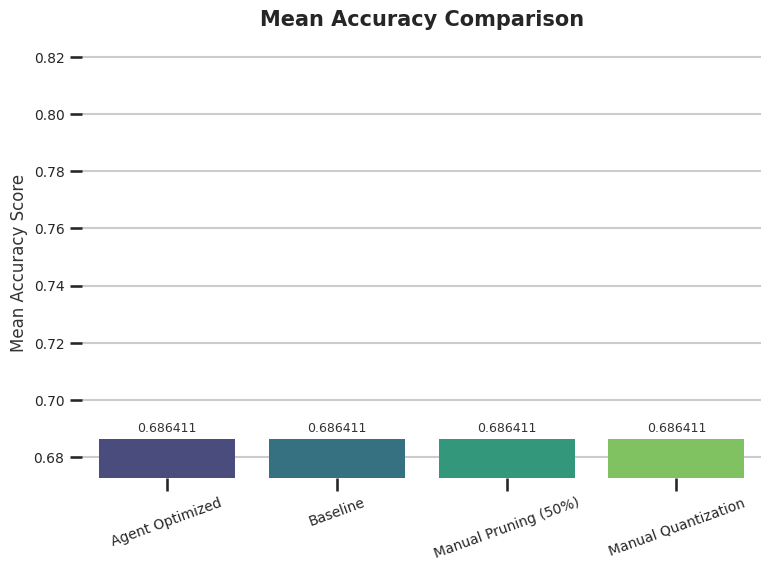

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


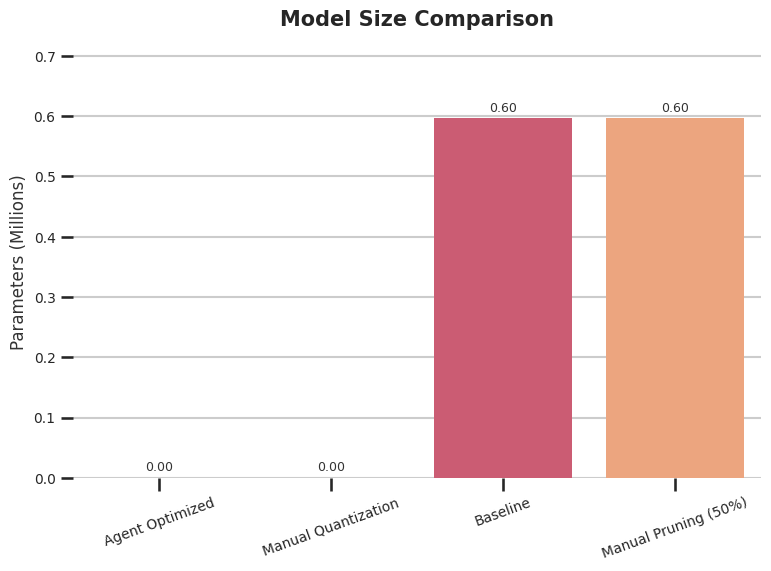

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


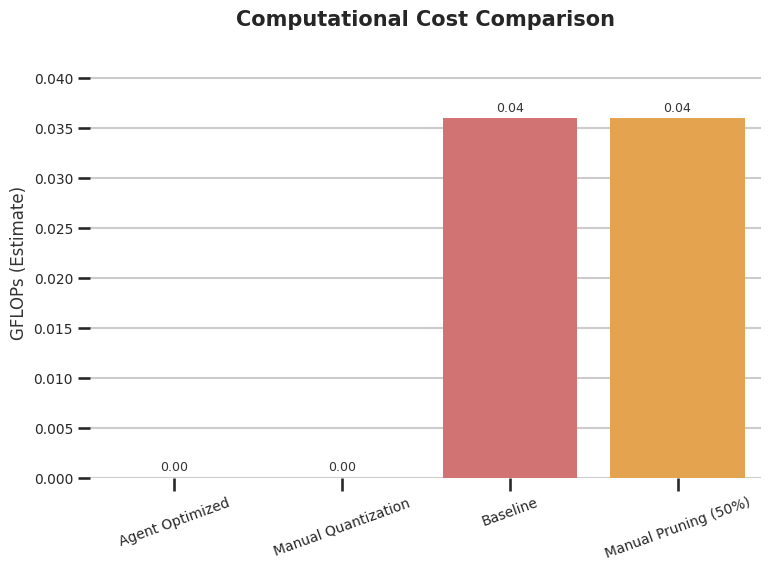

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


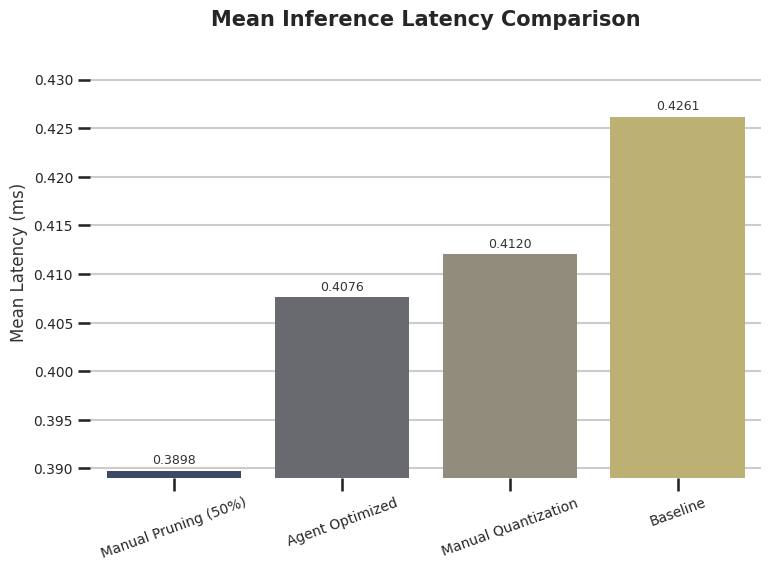

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


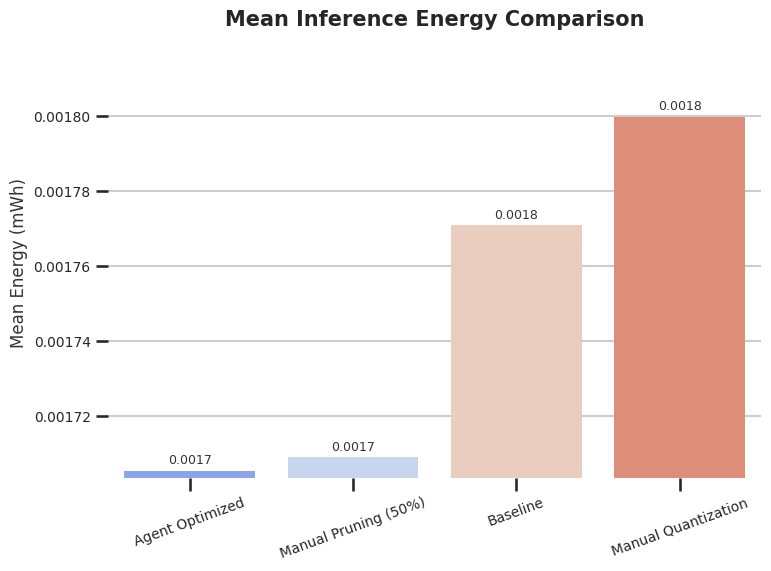

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if


--- Generating Pareto Plot (Mean Accuracy vs. Mean Inference Energy) ---


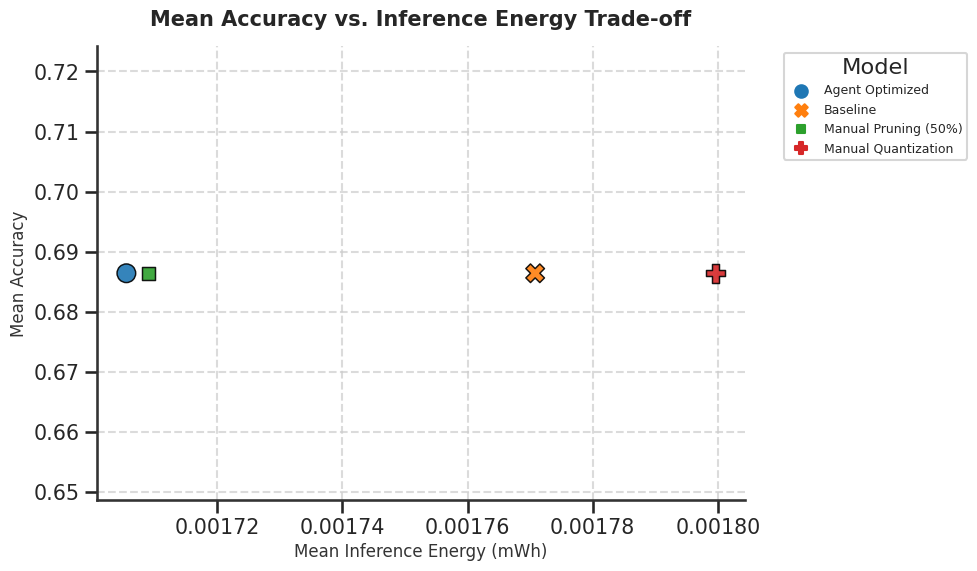

In [81]:
print("\n--- Generating Performance Comparison Visualizations (based on Mean values) ---")

if benchmark_results_df.empty:
    print("Skipping visualization: Benchmark results are not available.")
else:
    # Global style settings
    plt.style.use("seaborn-v0_8-whitegrid")
    sns.set_context("talk", font_scale=0.9)
    sns.set_palette("deep")
    plt.rcParams.update({
        "axes.edgecolor": "#333333",
        "axes.labelcolor": "#333333",
        "axes.titleweight": "bold",
        "axes.titlepad": 15,
        "grid.color": "#CCCCCC",
        "font.family": "DejaVu Sans",
        "figure.facecolor": "white"
    })

    metrics_to_plot = [
        {'metric': 'accuracy', 'palette': 'viridis', 'title': 'Mean Accuracy Comparison', 'ylabel': 'Mean Accuracy Score'},
        {'metric': 'params_m', 'palette': 'magma', 'title': 'Model Size Comparison', 'ylabel': 'Parameters (Millions)'},
        {'metric': 'flops_g', 'palette': 'plasma', 'title': 'Computational Cost Comparison', 'ylabel': 'GFLOPs (Estimate)'},
        {'metric': 'latency_ms', 'palette': 'cividis', 'title': 'Mean Inference Latency Comparison', 'ylabel': 'Mean Latency (ms)'},
        {'metric': 'energy_mwh', 'palette': 'coolwarm', 'title': 'Mean Inference Energy Comparison', 'ylabel': 'Mean Energy (mWh)'}
    ]

    for plot_info in metrics_to_plot:
        metric = plot_info['metric']

        if metric in benchmark_results_df.columns:
            try:
                plt.figure(figsize=(8, 6))
                ax = plt.gca()
                ascending_sort = (metric != 'accuracy')
                data_sorted = benchmark_results_df.sort_values(by=metric, ascending=ascending_sort)

                # Bar plot with gentle color gradient
                bars = sns.barplot(
                    x=data_sorted.index, y=metric, data=data_sorted, ax=ax,
                    palette=sns.color_palette(plot_info['palette'], len(data_sorted))
                )

                # Titles & labels
                ax.set_title(plot_info['title'], fontsize=15, weight='bold', pad=15)
                ax.set_ylabel(plot_info['ylabel'], fontsize=12)
                ax.set_xlabel('')
                ax.tick_params(axis='x', rotation=20, labelsize=10)
                ax.tick_params(axis='y', labelsize=10)
                sns.despine(left=True, bottom=True)

                # Add value annotations
                for container in bars.containers:
                    if metric in ['accuracy']:
                        fmt = "%.6f"
                    elif metric in ['energy_mwh', 'latency_ms']:
                        fmt = "%.4f"
                    else:
                        fmt = "%.2f"
                    bars.bar_label(container, fmt=fmt, padding=3, fontsize=9, color="#333333")

                # Dynamic Y limit
                min_val, max_val = data_sorted[metric].min(), data_sorted[metric].max()
                pad = (max_val - min_val) * 0.2 if max_val > min_val else max_val * 0.2 + 1e-6
                ax.set_ylim(bottom=max(0, min_val - pad * 0.1), top=max_val + pad)

                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"Warning: Could not plot {metric}: {e}")
                plt.figure(figsize=(10, 6))
                plt.title(f"{plot_info['title']} (Error)", fontsize=12, weight='bold')
                plt.text(0.5, 0.5, f"Error plotting {metric}", ha='center', va='center')
                plt.axis('off')
                plt.show()
        else:
            print(f"Skipping plot for '{metric}': Data not found.")
            plt.figure(figsize=(10, 6))
            plt.title(f"{plot_info['title']} (Data N/A)", fontsize=12, weight='bold')
            plt.text(0.5, 0.5, f"Data for {metric} not available", ha='center', va='center')
            plt.axis('off')
            plt.show()

    # --- Pareto Plot ---
    print("\n--- Generating Pareto Plot (Mean Accuracy vs. Mean Inference Energy) ---")

    if {'energy_mwh', 'accuracy'}.issubset(benchmark_results_df.columns):
        try:
            plt.figure(figsize=(12, 6))
            plot_df = benchmark_results_df.copy()

            scatter = sns.scatterplot(
                data=plot_df, x='energy_mwh', y='accuracy', hue=plot_df.index,
                s=180, style=plot_df.index, palette='tab10', alpha=0.9, edgecolor='black'
            )

            plt.title('Mean Accuracy vs. Inference Energy Trade-off', fontsize=15, weight='bold')
            plt.xlabel('Mean Inference Energy (mWh)', fontsize=12)
            plt.ylabel('Mean Accuracy', fontsize=12)
            plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, frameon=True)
            plt.grid(True, linestyle='--', alpha=0.7)

            sns.despine()
            plt.tight_layout(rect=[0, 0, 0.85, 1])
            plt.show()

        except Exception as e:
            print(f"Warning: Could not generate Pareto plot: {e}")
    else:
        print("Skipping Pareto plot: Required columns ('energy_mwh', 'accuracy') not found.")
